# News Classification Using NLP
### Minor Project 1 

`Rohit Tudu (1076CD221115), Vibhi Verma (0176CD221151)`

`CSE-Data Science 5th Sem`

## Problem Statement

Automatically classifying news articles into categories like business, entertainment, politics, sports, and technology is a critical task. This project aims to develop a machine learning model that can efficiently and accurately categorize news articles using NLP and machine learning techniques.

**Dataset**: [BBC News Classification Dataset](http://mlg.ucd.ie/datasets/bbc.html).

**Techniques Used**:
- Natural Language Processing (NLP)
- TF-IDF (Term Frequency-Inverse Document Frequency)
- Non-Negative Matrix Factorization (NMF)
- Supervised Learning (Logistic Regression, Naive Bayes, Support Vector Machine)

In [20]:
import pandas as pd
import numpy as np

import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data Input and Pre-processing

We will load the BBC News dataset from a local CSV file, which contains two columns: the article text and its corresponding category. The categorical variable (news category) will be encoded into integers for better performance in machine learning algorithms.

Pre-processing steps:

1. **Load the dataset**: Using Pandas to load the CSV file.
2. **Category Encoding**: Convert categories (business, entertainment, politics, sport, tech) into integers with `LabelEncoder`.
3. **Text Vectorization**: Transform the text into numerical format using `TfidfVectorizer` to get TF-IDF scores.
4. **Train-Test Split**: Split the data into 1,490 training samples and 735 testing samples.

The dataset can be accessed from the original source [BBC News Classification Dataset](http://mlg.ucd.ie/datasets/bbc.html).

These steps prepare the data for building a model to predict the news category from the article content.

In [21]:
# Load data
data_path = r"dataset/BBC_News_Train.csv"
data = pd.read_csv(data_path)

# Use factorize to prepare the CategoryId
data['CategoryId'] = data.Category.factorize()[0]

category_df = data[['Category','CategoryId']].drop_duplicates().sort_values('CategoryId')
category2id = dict(category_df.values)
id2category = dict(category_df[['CategoryId','Category']].values)

### Data Inspection

Data inspection helps identify issues and assess dataset quality. Key tasks include:

1. **Check for Missing Values**: Ensure no missing text or category data.
2. **Category Distribution**: Visualize article counts per category to identify imbalances.
3. **Text Length Analysis**: Check article lengths for outliers.
4. **Sample Review**: Inspect random samples for correctness.

This step guides data cleaning and feature engineering.

In [22]:
# Shape of the data
print(f"Shape of data: {data.shape}\n")

# Check the column names
print(f"Column names: {data.columns}\n")

# check for missing values
print(f"Check for missing Values: \n{data.isnull().sum()}\n")

# Peek to first few rows
print(f"{data.head()}\n")

# Check the distribution of categories
data['Category'].value_counts()

Shape of data: (1490, 4)

Column names: Index(['ArticleId', 'Text', 'Category', 'CategoryId'], dtype='object')

Check for missing Values: 
ArticleId     0
Text          0
Category      0
CategoryId    0
dtype: int64

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   CategoryId  
0           0  
1           0  
2           0  
3           1  
4           0  



Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

### Text Preprocessing

Text preprocessing transforms raw text into a structured format for modeling. Key techniques include:

1. **Tokenization**: Splitting text into individual words or tokens.
2. **Stemming/Lemmatization**: Reducing words to their root form (e.g., "running" to "run").
3. **Stopword Removal**: Removing common words (e.g., "and", "the") that don't contribute to analysis.
4. **Normalization**: Converting text to lowercase, removing punctuation, and handling special characters.

These steps help standardize the data, reduce dimensionality, and improve model performance for classification.

In [23]:
# Loading necessary resources
def load_stopwords():
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')

load_stopwords()

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    words = nltk.word_tokenize(text=text, language='english')

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Ensure data is a DataFrame and handle null values
data['Text'] = data['Text'].fillna('')  # Handle NaN values
data['Text'] = data['Text'].astype(str)  # Ensure text column is strings

# Apply preprocessing
data['CleanText'] = data['Text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/ragefire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ragefire/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ragefire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration

Before training models, it's important to understand the dataset's structure. This guides the modeling process.

Key steps include:

- **Reviewing Random Samples**: Inspect random examples to understand the content.
- **Class Distribution**: Analyze the number of samples in each category to detect potential imbalances.

In [24]:
data.sample(5, random_state=0)

,ArticleId,Text,Category,CategoryId,CleanText
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4,focker fuel festiv film chart comedi meet fock...
354,1349,tory candidate quits over remark a conservativ...,politics,2,tori candid quit remark conserv elect challeng...
1227,1572,bath faced with tindall ultimatum mike tindall...,sport,3,bath face tindal ultimatum mike tindal agent w...
907,1155,chancellor rallies labour voters gordon brown ...,politics,2,chancellor ralli labour voter gordon brown iss...
575,307,young debut cut short by ginepri fifteen-year-...,sport,3,young debut cut short ginepri fifteen-year-old...


### Number of Documents per Category: 

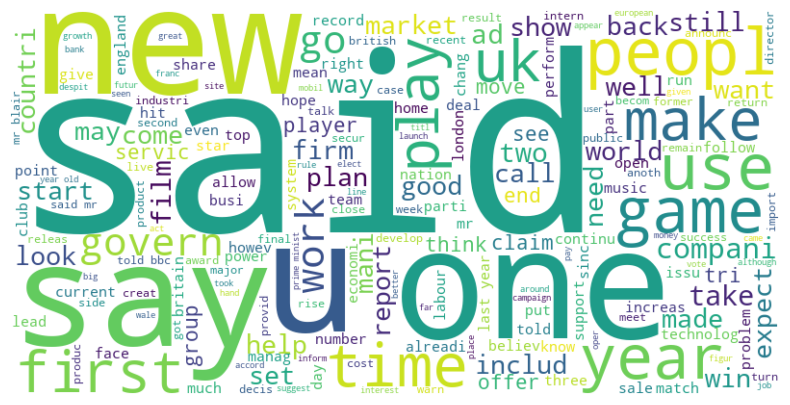

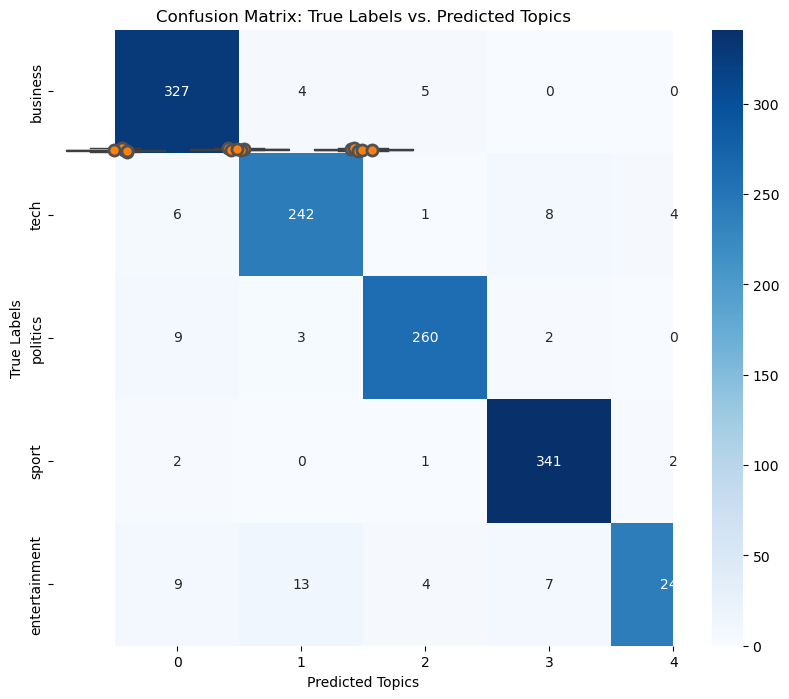

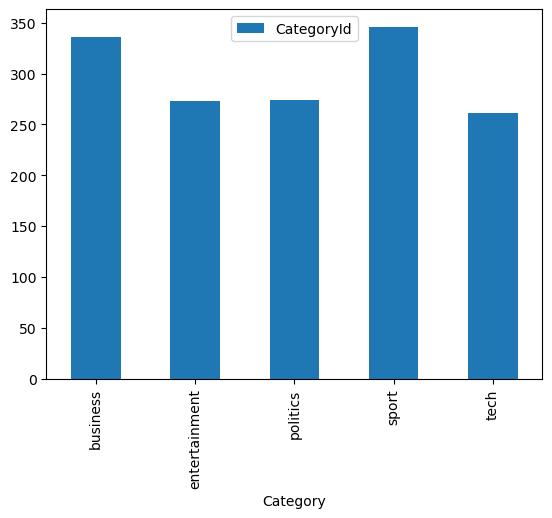

In [25]:
data[['Category','CategoryId']].groupby('Category').count().plot.bar(ylim=0)
plt.show()

The class distribution shows that the number of articles per category is roughly balanced, which is ideal for training. If the dataset were imbalanced, we would need to adjust the model or apply techniques like oversampling or undersampling to correct the imbalance.

Show the Word Cloud of the Articles:

In [26]:
text = ' '.join(data['CleanText'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

Analyzing the Word Cloud reveals:

- **Common Function Words**: Words like "said," "say," "one," and "people" are frequent but may not aid in classification.
- **Topic-Specific Words**: Terms like "film," "govern," and "company" highlight themes relevant to entertainment and politics, important for classification.

Show the Word Frequency of the articles:

In [27]:
def get_word_counts(text_data):
  all_words = []
  for text in text_data:
    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    all_words.extend(words)
  word_counts = Counter(all_words)
  word_freq = pd.DataFrame({'word': list(word_counts.keys()), 'count': list(word_counts.values())})
  word_freq = word_freq.sort_values(by='count', ascending=False)
  return word_freq

word_freq = get_word_counts(data['CleanText'])
word_freq.head(20)

,word,count
75,said,4838
39,mr,2006
112,year,1853
160,would,1711
83,also,1426
65,new,1334
286,peopl,1324
27,us,1234
384,one,1190
336,say,1050


Based on the Word Frequency data, we observe:

- **Function Words**: Common words like "said," "would," and "could" appear frequently but don't help much in classification.
- **Key Topics**: Words such as "people," "government," and "time" indicate social or political themes.
- **Domain-Specific Terms**: Words like "game," "film," and "tech" suggest specific topics relevant to the articles.

## Building and Training Models

### Feature Extraction

To apply machine learning, we need to convert article text into feature vectors. We’ll use **TF-IDF (Term Frequency-Inverse Document Frequency)** to capture the importance of words within each document and across the entire dataset. This process creates a document-term matrix where:

- **Rows** represent individual articles.
- **Columns** represent unique words.

This transformation allows the model to interpret the text based on the relevance of terms in the dataset.

In [28]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = vectorizer.fit_transform(data.Text).toarray()
features.shape

(1490, 5000)

### Non-Negative Matrix Factorization (NMF)

We will use Non-Negative Matrix Factorization (NMF) to decompose the document-term matrix into two lower-dimensional matrices:

- **W (Document-Topic Matrix)**: Rows represent documents, and columns represent topics, with values showing the contribution of each topic to a document.
- **H (Topic-Term Matrix)**: Rows represent topics, and columns represent words, with values indicating each word's importance to a topic.

We’ll create an NMF model with `n_components=5` and `random_state=42`, with the possibility of adjusting hyperparameters for better accuracy.

In [29]:
# Define the number of topics
num_topics = 5

# Training the NMF model
nmf = NMF(n_components=num_topics, random_state=42)
topic_matrix = nmf.fit_transform(features)

### Analyzing the Topic-Term Matrix (H)

We will analyze the `H` matrix (topic-term matrix) to identify key words for each topic. Words with high values in a column are most relevant to that topic. Using the `argmax()` function, we will pinpoint the most significant words for each topic, helping us interpret the underlying themes and better understand the dataset.

In [30]:
# Assign topics to articles
data['predicted_topic'] = topic_matrix.argmax(axis=1)

The `factorize()` function assigns integer labels (0 to \( n-1 \)) for unique labels, while NMF topics are also numbered 0 to \( n-1 \). However, these numbers may not align, causing confusion.

To improve clarity, we will map the NMF topics to the original category labels based on their highest contribution, ensuring a more intuitive interpretation of the results.

In [31]:
# Align NMF topics with given labels
def alignTopicToLabel():
    topic_to_label = {}
    for topic in range(num_topics):
        labels = data[data['predicted_topic'] == topic]['CategoryId']
        if len(labels) > 0:
            topic_to_label[topic] = labels.mode().iloc[0]
        else:
            topic_to_label[topic] = -1  # Assign -1 if no articles in this topic
    return topic_to_label
topic_to_label = alignTopicToLabel()
data['aligned_topic'] = data['predicted_topic'].map(topic_to_label)

This approach aligns NMF topics with encoded labels based on the most frequent label in each topic, making it easier to compare the discovered topics with the actual categories.

While this alignment improves interpretability, its accuracy depends on how well the topics match the real categories. It serves as a post-hoc interpretation of the NMF results.

Next, we can analyze the most important words in each topic to label and interpret them in a human-readable way. This process is useful in unsupervised learning, where predefined labels are unavailable, helping us uncover meaningful themes and improve the model’s interpretability.

In [32]:
# Get the most important words for each topic
feature_names = vectorizer.get_feature_names_out()
word_importance = nmf.components_

for topic_idx, topic in enumerate(word_importance):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]]
    topic_name = id2category[topic_to_label[topic_idx]]
    print(f"Topic {topic_name}: {', '.join(top_words)}")

Topic tech: people, users, technology, mobile, digital
Topic sport: game, win, england, cup, team
Topic politics: mr, labour, election, blair, party
Topic entertainment: film, best, awards, actor, award
Topic business: growth, said, market, economy, year


Based on the top word analysis, the NMF model has successfully identified distinct topics within the dataset. We can apply this approach to the test dataset, using the same topic modeling techniques to uncover underlying themes and better understand the articles. This will allow us to evaluate the model's ability to categorize unseen data effectively.

## Model Evaluation

Evaluating model performance is essential to understand how well it generalizes to unseen data. The `classification_report` function from scikit-learn provides a detailed overview of a classification model’s performance:

- **Detailed Breakdown**: It gives metrics like **Precision**, **Recall**, **F1-score**, and **Support** for each class in a multi-class problem.
  
- **Averaging Metrics**: It calculates macro and weighted averages, summarizing the model's overall performance across all classes for easier interpretation.

In [33]:
target_names = data.Category.unique()
print("\nClassification Report:")
print(classification_report(data.CategoryId, data['aligned_topic'], target_names=target_names))


Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.97      0.95       336
         tech       0.92      0.93      0.93       261
     politics       0.96      0.95      0.95       274
        sport       0.95      0.99      0.97       346
entertainment       0.98      0.88      0.92       273

     accuracy                           0.95      1490
    macro avg       0.95      0.94      0.94      1490
 weighted avg       0.95      0.95      0.95      1490



Based on the classification report, the following conclusions can be made:

- **Accuracy**: The model achieves 95% accuracy, correctly classifying 95% of the documents.

- **Macro and Weighted Averages**: The macro and weighted averages for precision, recall, and F1-score are around 0.95, indicating consistent performance across all categories.

- **Individual Class Performance**: All categories show precision, recall, and F1-score values above 0.90, reflecting strong performance. 

  - The **"Sport"** category has the highest recall (0.99), meaning the model effectively identifies relevant sports articles.
  
  - The **"Business"** category has the lowest precision (0.93), suggesting some false positives in this category.

The confusion matrix provides valuable insights into model performance by highlighting misclassifications. It shows how many articles were correctly classified and how many were misclassified into other categories, helping identify common mistakes.

In the confusion matrix:

- **Rows** represent the actual classes (true labels).
- **Columns** represent the predicted classes (from the NMF model).
- **Diagonal Elements** indicate correctly classified articles.
- **Off-Diagonal Elements** show misclassified documents.

This visualization helps assess the model's accuracy and guides improvements by identifying areas where the model can be fine-tuned.

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(data.CategoryId, data['aligned_topic']), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_topics), yticklabels=target_names)
plt.title('Confusion Matrix: True Labels vs. Predicted Topics')
plt.xlabel('Predicted Topics')
plt.ylabel('True Labels')

Text(95.72222222222221, 0.5, 'True Labels')

Overall, the model performs well, as evidenced by the high number of correct classifications on the confusion matrix diagonal. However, some individual classes show the following:

- **Sport**: With 341 correctly classified documents and few misclassifications, the model is highly effective at identifying sports articles.

- **Entertainment**: This category has 246 correct classifications but more misclassifications, particularly with tech and business categories. This suggests the model struggles to distinguish some entertainment articles from these topics.

## Model Tuning

To improve model performance, we will analyze the top words and assess whether adjustments to model parameters (e.g., number of topics, initialization method) or preprocessing steps (e.g., stopwords, n-grams) are needed. 

We will modify NMF hyperparameters, such as the number of topics or initialization method, and evaluate the model's accuracy. This iterative tuning process will help refine the model and enhance classification results.

In [35]:
# Here we set init method as 'random' and set solver method as 'mu'
nmf = NMF(init='random', n_components=num_topics, random_state=42, solver='mu')
topic_matrix = nmf.fit_transform(features)
data['predicted_topic'] = topic_matrix.argmax(axis=1)
topic_to_label = alignTopicToLabel()
data['aligned_topic'] = data['predicted_topic'].map(topic_to_label)
nmf_accuracy = accuracy_score(data.CategoryId, data['aligned_topic'])
# We will use nmf_accuracy to compare the nmf accuracy with the supervised learning models later
nmf_accuracy

0.9489932885906041

After modifying the model hyperparameters, the accuracy score of 0.9490 indicates a slight improvement. This suggests that while we have achieved better performance, further enhancements may be challenging, as it becomes increasingly difficult to improve accuracy when it is already high. This highlights the importance of focusing on other aspects of model performance, such as precision and recall, in addition to accuracy.


## Supervised Learning Algorithms

We will benchmark the following models:

- **Logistic Regression**: A statistical method that predicts the probability of a class based on independent variables. It is widely used for classification tasks, including multi-class problems, by modeling the relationship between features and class probabilities using a logistic function.

- **Naive Bayes**: A probabilistic classifier based on Bayes' theorem, assuming feature independence. It performs well for text classification tasks by calculating class probabilities and selecting the class with the highest likelihood.

- **Support Vector Machine (SVM)**: A classifier that finds the optimal hyperplane separating different classes. Effective for complex tasks, SVM works well with both linear and non-linear data, especially with the use of kernel functions.

To evaluate the models, we will use cross-validation, which splits the dataset into multiple subsets for training and testing. This method ensures that the model is evaluated on different portions of the data, helping to prevent overfitting and providing a more reliable performance estimate.

The `cross_val_score` function from scikit-learn will be used to calculate the model’s performance across different subsets. This approach allows for flexible evaluation based on various metrics, helping us assess the generalization ability of each model on unseen data.

In [36]:
labels = data.CategoryId

models = [SVC(kernel='linear', gamma=5),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append([model_name, fold_idx, accuracy])
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, linewidth=2)

<Axes: title={'center': 'Confusion Matrix: True Labels vs. Predicted Topics'}, xlabel='Predicted Topics', ylabel='True Labels'>

This boxplot compares the cross-validation accuracy scores for three different machine learning models: SVC (Support Vector Classifier), MultinomialNB (Multinomial Naive Bayes), and Logistic Regression. 

All three models perform well, with median accuracies exceeding 0.97. Notably, the SVC model appears to be the most accurate and consistent for this particular dataset and cross-validation setup, indicating its effectiveness in handling the classification task at hand.


### NMF Model vs. Supervised Learing Models

In [37]:
cv_df.loc[len(cv_df)] = ["NMF", 0, nmf_accuracy]
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.974497
MultinomialNB         0.970470
NMF                   0.948993
SVC                   0.977852
Name: accuracy, dtype: float64

Based on the above results, we can make the following observations:

- The supervised learning models exhibit very similar, high accuracy scores, ranging from 0.9704 to 0.9778, while the NMF model has a significantly lower accuracy score of 0.9490.
- The overall high accuracy scores suggest that the supervised models are performing well on the given dataset.
- The small differences in accuracy between the supervised learning models may not be statistically significant.
- The NMF model is primarily designed for dimensionality reduction and topic modeling, rather than classification, so its lower performance in this context is expected.


## Predict Test Dataset

Based on the accuracy benchmark, we will select the SVC model for predicting the test dataset. We will create the SVC model using the best hyperparameters found through GridSearch and then proceed to make predictions on the test dataset.


In [38]:
data_test_path = r"dataset/BBC_News_Test.csv"
data_test = pd.read_csv(data_test_path)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(features)
y_train = data.CategoryId

# Create the SVC model with GridSearchCV searched best parameters(finished running offline)
svc = SVC(C = 0.1, kernel='linear', gamma=5, random_state=42)

# Fit the grid search to the data
svc.fit(X_train, y_train)

# Extract test features from test dataset
features_test = vectorizer.fit_transform(data_test.Text).toarray()

# Make predictions on the test set
features_test = scaler.transform(features_test)
category_ids = svc.predict(features_test)

# Convert each category id to category name
categories = [id2category[id] for id in category_ids]
# Create test set prediction file
final_dict = {"ArticleId": data_test.ArticleId, "Category":categories}
final_df = pd.DataFrame(final_dict)
final_df.to_csv('submission.csv',index=False)

final_df.head()

,ArticleId,Category
0,1018,sport
1,1319,politics
2,1138,entertainment
3,459,tech
4,1020,sport
